<div align='center'><font size="5" color='#353B47'>Predicting Stock Prices</font></div>
<div align='center'><font size="4" color="#353B47">How to use LSTMs</font></div>
<br>
<hr>

**<font color="blue" size="4">Context</font>**

> This notebook aims at showing a short script on how to predict stock prices using a LSTM model. An introduction has been made about <a href="https://www.kaggle.com/bryanb/introduction-to-time-series-analysis/edit/run/53321733">Time Series Analysis</a>, if you haven't read it yet, do not hesitate to give a look

**<font color="blue" size="4">Reminder</font>**

> A Time Series is a **time-indexed** series of data. In Finance, a time series tracks the movement of the chosen data points, such as a *security's price*, over a specified period of time with data points recorded at **regular intervals**.

<img src="https://miro.medium.com/max/1400/1*NpT5pyemQQsGEHXbfS51Zw.png" width="500">

**<font color="blue" size="4">Why is it used for ?</font>**

> Time series analysis can be useful to see how a given asset, security, or economic variable changes over time. It can also be used to examine how the changes associated with the chosen data point compare to shifts in other variables over the same time period.
>
> For example, suppose you wanted to analyze a time series of daily closing stock prices for a given stock over a period of one year. You would obtain a list of all the closing prices for the stock from each day for the past year and list them in chronological order. 

## <div id="summary">Summary</div>

**<font size="2"><a href="#chap1">1. Import libraries</a></font>**
**<br><font size="2"><a href="#chap2">2. Preprocessing</a></font>**
**<br><font size="2"><a href="#chap3">3. Build LSTM model</a></font>**
**<br><font size="2"><a href="#chap4">4. Training</a></font>**
**<br><font size="2"><a href="#chap5">5. Predictions</a></font>**

# <div id="chap1">1. Import libraries

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
# import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import yfinance as yf

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap2">2. Preprocessing

In [3]:
COMPANY = '^GSPC'


In [4]:
data = yf.download(COMPANY, start='2000-01-01', end='2022-01-01')
len(data)

[*********************100%***********************]  1 of 1 completed


5536

In [5]:
array_data = np.array(data['Close'])
n_data = array_data.size
time_data = np.arange(0, n_data)
Polynomial = np.polyfit(time_data, array_data, 1)
data_notrend = array_data - Polynomial[0] * time_data  # detrended x
data['Close'] = data_notrend

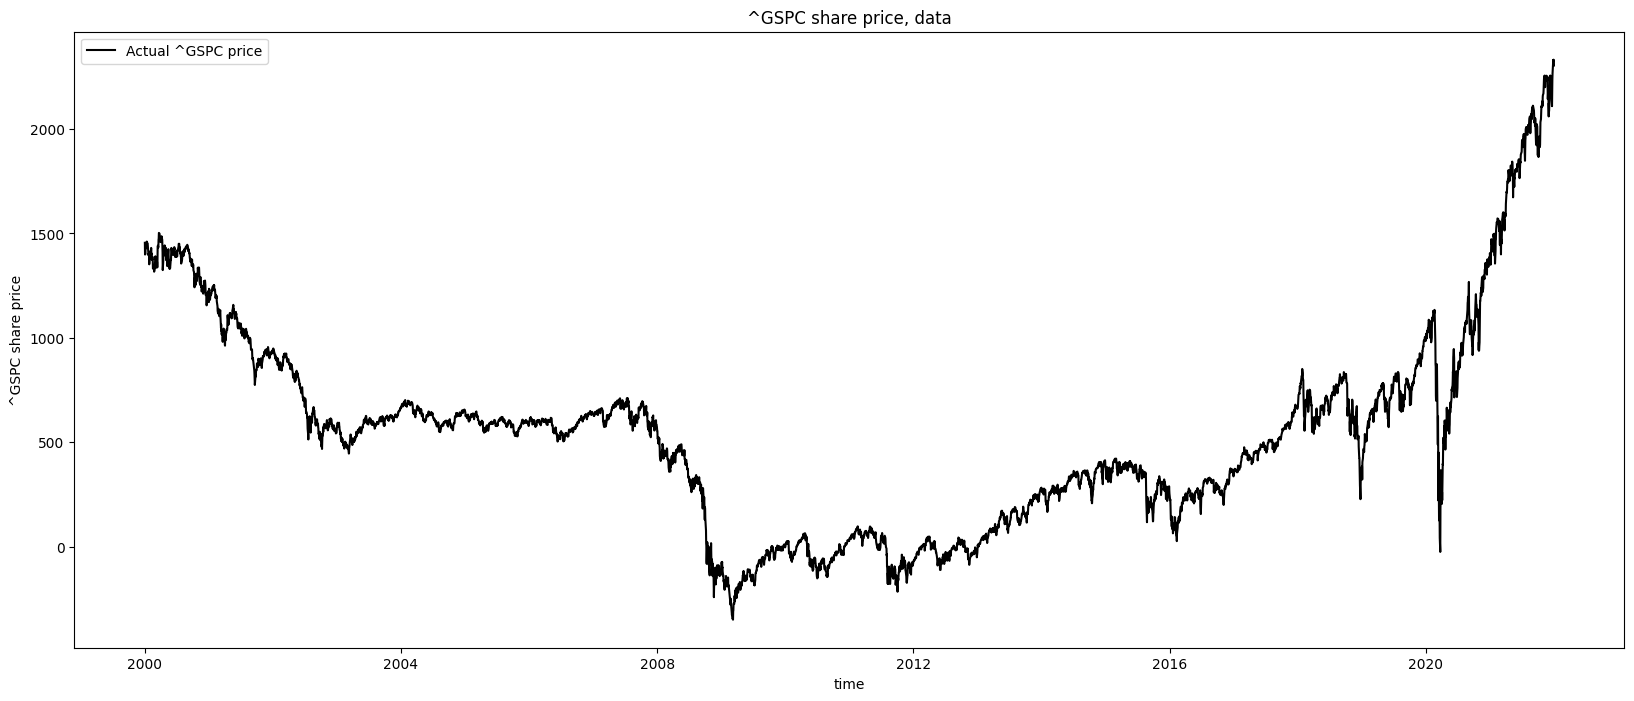

In [6]:
plt.figure(figsize=(20, 8))
plt.plot(data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, data")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [7]:
import math
math.ceil(len(data)*0.8)

4429

In [8]:
train_data = data[0:math.ceil(len(data)*0.8)]
print(len(train_data))
test_data = data[math.ceil(len(data)*0.8):]
print(len(test_data))

4429
1107


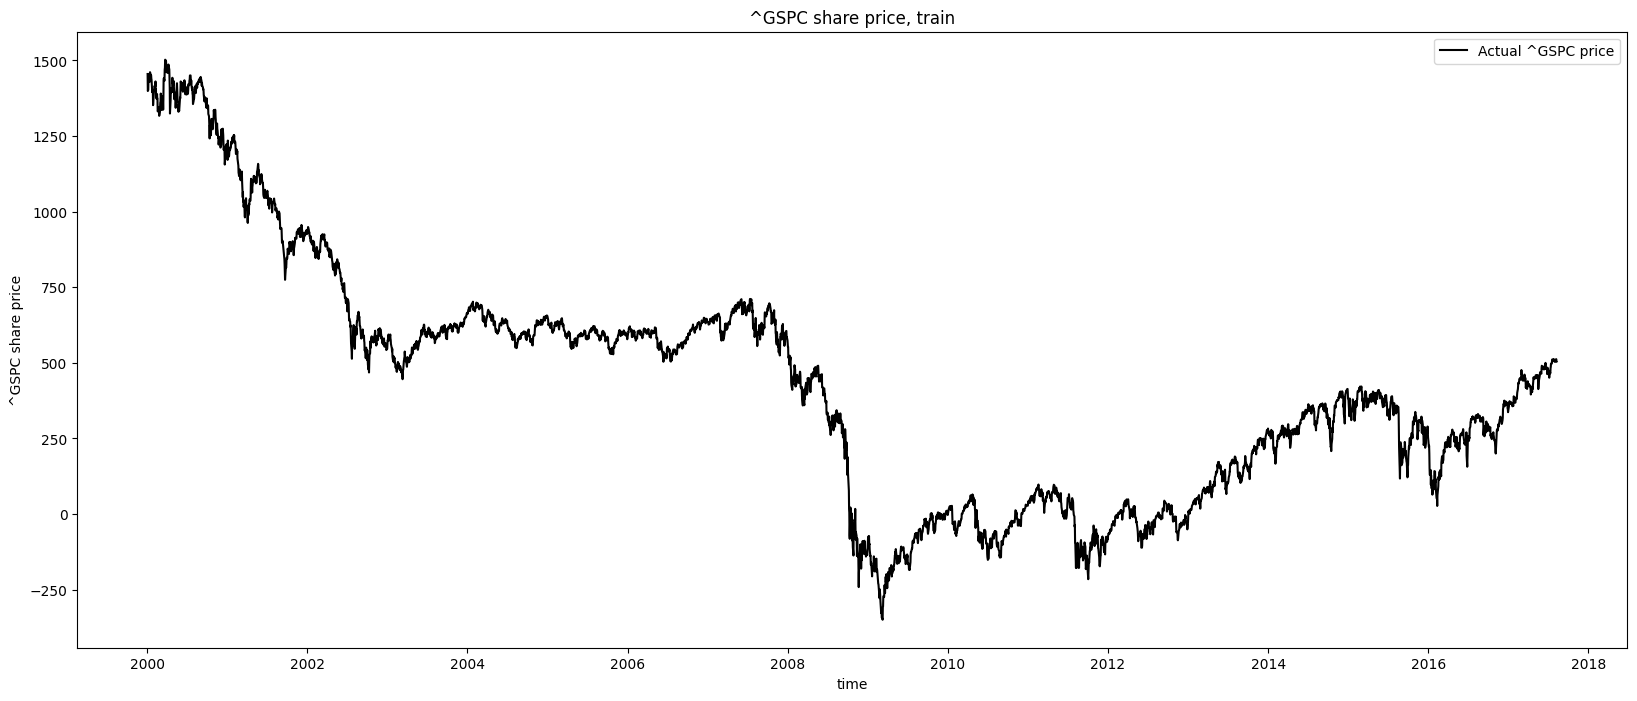

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(train_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, train")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

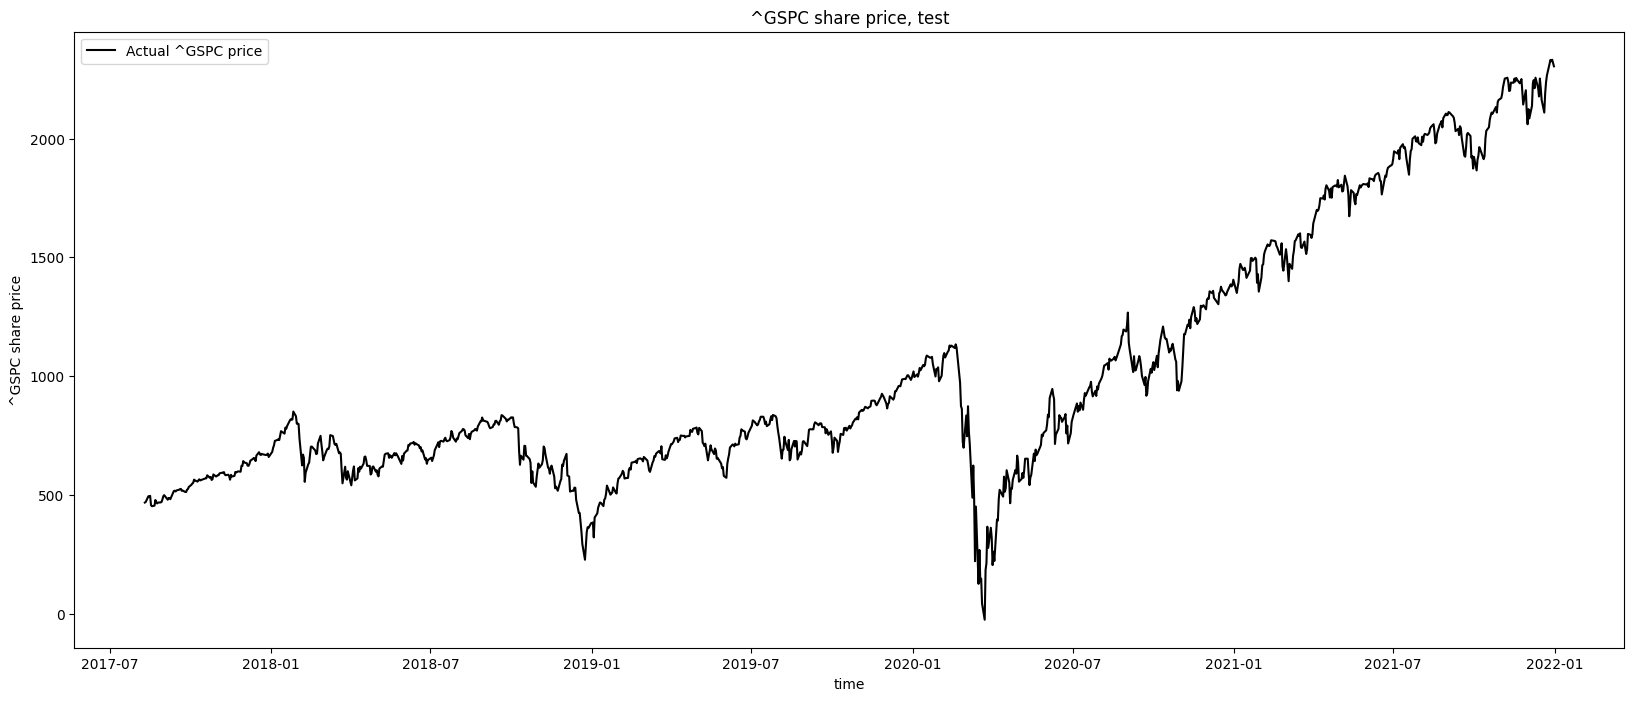

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(test_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, test")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [11]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

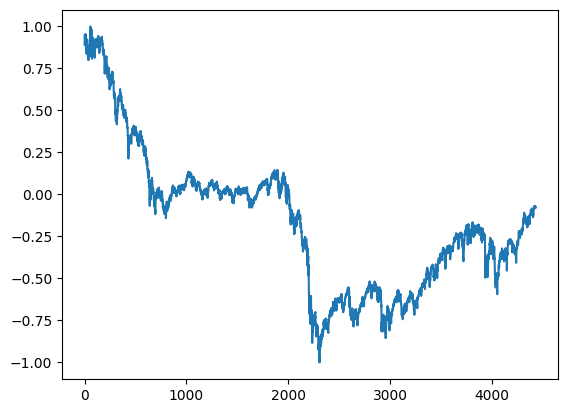

In [12]:
plt.plot(scaled_data)

In [13]:
# how many days do i want to base my predictions on ?
base_day = 50
prediction_day = 50
x_train = []
y_train = []
# 從base_day開始，往前提取base_day天的數據，作為輸入變量x_train，並將當前價格作為輸出變量y_train
for x in range(base_day+prediction_day, len(scaled_data), prediction_day):
    x_train.append(scaled_data[x-base_day-prediction_day:x-prediction_day, 0])
    y_train.append(scaled_data[x-prediction_day:x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
x_train.shape

(87, 50, 1)

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap3">3. Build LSTM model

**<font color="blue" size="4">What is a LSTM ?</font>**

> Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. Introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.
>
> LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!
>
> All recurrent neural networks have the form of a chain of repeating modules of neural network.

You can find more details here: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [15]:
def LSTM_model(prediction_day):
    
    model = Sequential()
    
    model.add(LSTM(units = 500, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 500, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 500))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=prediction_day))
    
    return model

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap4">4. Training

In [16]:
# model = LSTM_model()
# model.summary()
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define callbacks
# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
# earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)

# history = model.fit(x_train, y_train, epochs=25, batch_size = 32, callbacks = [checkpointer, earlystopper], validation_split = 0.2)

# # plot loss curves
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show()


In [17]:
model = LSTM_model(prediction_day)
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 500)           1004000   
                                                                 
 dropout (Dropout)           (None, 50, 500)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 500)           2002000   
                                                                 
 dropout_1 (Dropout)         (None, 50, 500)           0         
                                                                 
 lstm_2 (LSTM)               (None, 500)               2002000   
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense (Dense)               (None, 50)                2

In [18]:
# # Define callbacks

# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
#                                verbose = 2, 
#                                save_best_only = True)

# model.fit(x_train, 
#           y_train, 
#           epochs=25, 
#           batch_size = 32,
#           callbacks = [checkpointer])

In [19]:
# Define callbacks
# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)

history = model.fit(x_train, y_train, epochs=10, batch_size = 10, callbacks = [checkpointer, earlystopper], validation_split = 0.2)


Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 0.1007
Epoch 1: val_loss improved from inf to 0.00772, saving model to weights_best.hdf5
7/7 [==============================] - 12s 989ms/step - loss: 0.1007 - val_loss: 0.0077
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 0.0308
Epoch 2: val_loss did not improve from 0.00772
7/7 [==============================] - 5s 776ms/step - loss: 0.0308 - val_loss: 0.0153
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.0358
Epoch 3: val_loss did not improve from 0.00772
7/7 [==============================] - 5s 783ms/step - loss: 0.0358 - val_loss: 0.0118
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 0.0211
Epoch 4: val_loss improved from 0.00772 to 0.00636, saving model to weights_best.hdf5
7/7 [==============================] - 5s 748ms/step - loss: 0.0211 - val_loss: 0.0064
Epoch 5/10
7/7 [==============================] - ETA: 0s - loss: 0.0155
Epoch 5: val_loss improv

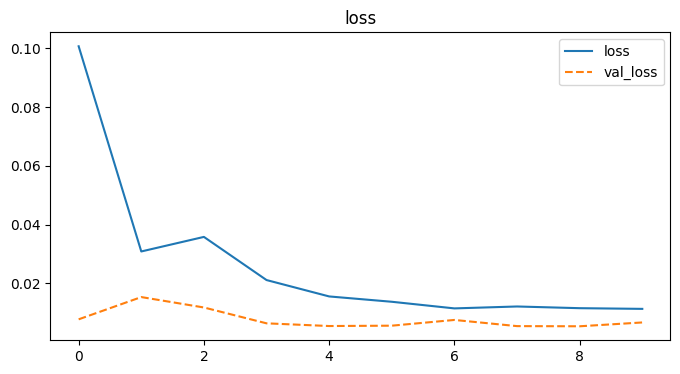

In [20]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()


**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap5">5. Predictions

In [21]:
# test model accuracy on existing data

actual_prices = test_data['Close'].values
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-base_day:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

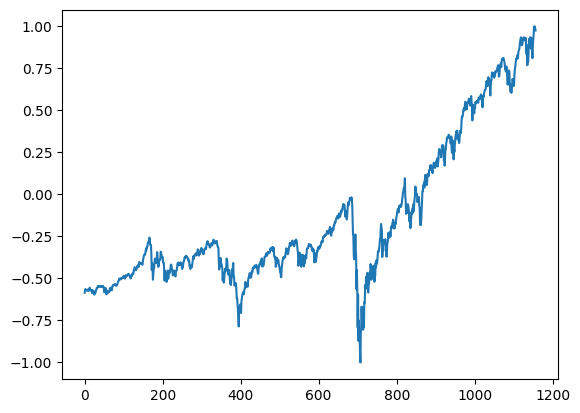

In [22]:
plt.plot(model_inputs)

In [23]:
x_test = []
y_test = []
for x in range(base_day+prediction_day, len(model_inputs), prediction_day):
    x_test.append(model_inputs[x-base_day-prediction_day:x-prediction_day, 0])
    y_test.append(model_inputs[x-prediction_day:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
# predicted_prices = scaler.inverse_transform(predicted_prices)
print(f"predicted_prices: {predicted_prices[0]}")
print(f"predicted_prices: {predicted_prices[5]}")

1/1 [==============================] - 2s 2s/step
predicted_prices: [-0.51893437 -0.51216936 -0.5559671  -0.5081199  -0.5779717  -0.5918474
 -0.5610181  -0.5329461  -0.5736342  -0.5345476  -0.5539735  -0.50961864
 -0.54592025 -0.58373773 -0.5635793  -0.52946734 -0.506404   -0.50842375
 -0.56555897 -0.5431878  -0.53492033 -0.49885786 -0.5089026  -0.52673405
 -0.5875105  -0.5240002  -0.47923622 -0.51429236 -0.5319097  -0.5381824
 -0.5431018  -0.56657493 -0.5632762  -0.58471525 -0.5507433  -0.459653
 -0.5180983  -0.53774697 -0.5927832  -0.54605204 -0.58237004 -0.5329442
 -0.5785489  -0.5167324  -0.53991914 -0.5291572  -0.51245356 -0.5441015
 -0.5157119  -0.52774554]
predicted_prices: [-0.34887183 -0.3429813  -0.37177512 -0.33294055 -0.3861823  -0.39919344
 -0.37800506 -0.35925236 -0.3906816  -0.36213055 -0.3783976  -0.34329912
 -0.37409857 -0.3952207  -0.38066816 -0.35675046 -0.34415117 -0.3392924
 -0.38476923 -0.36369267 -0.36012545 -0.33662808 -0.33930615 -0.35517722
 -0.39917928 -0.358

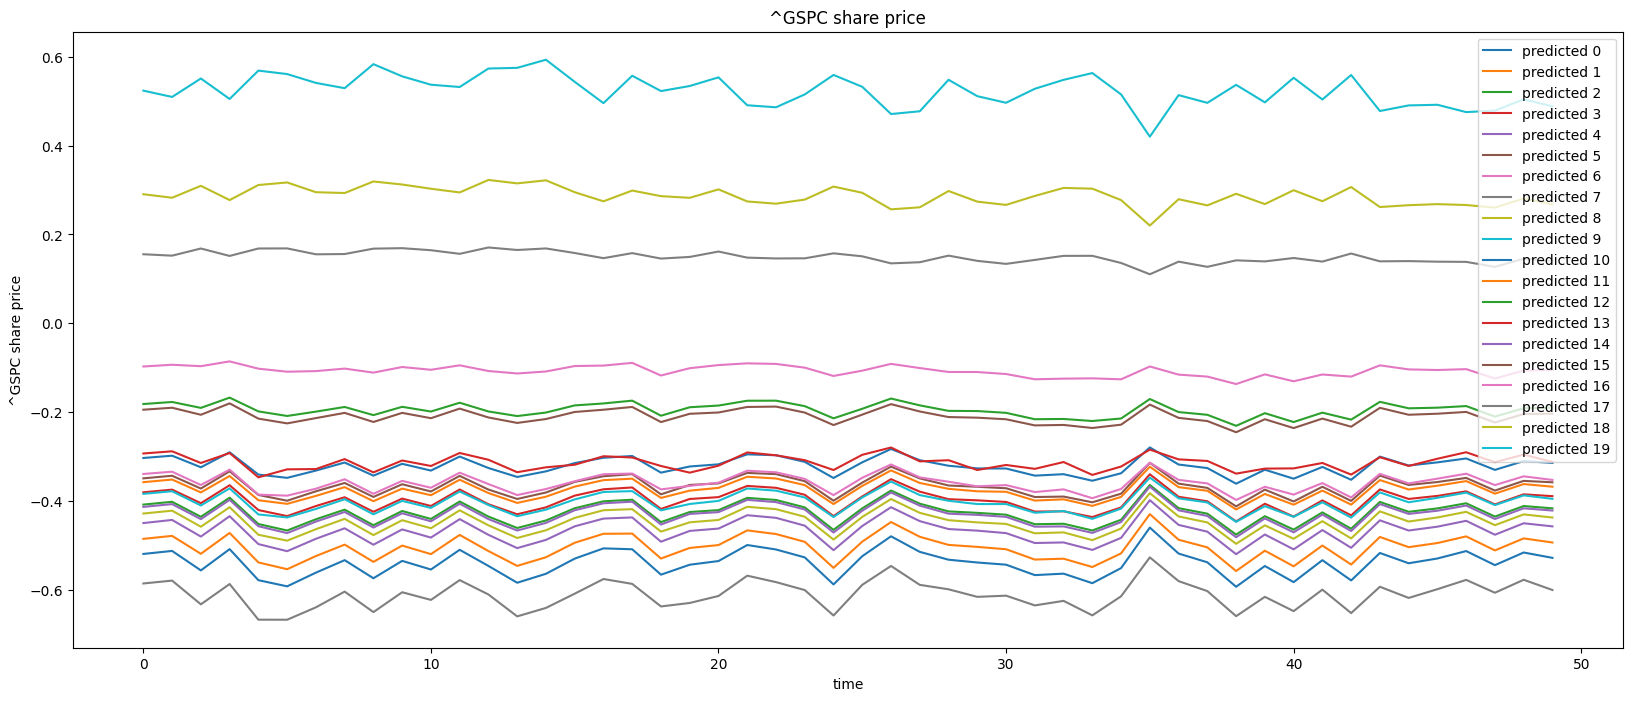

In [31]:
plt.figure(figsize=(20, 8))
for i in range(0, 20):
    plt.plot(predicted_prices[i], label=f"predicted {i}")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
# plt.xlim(0, 9)
# plt.ylim(400, 510)
plt.legend()
plt.show()

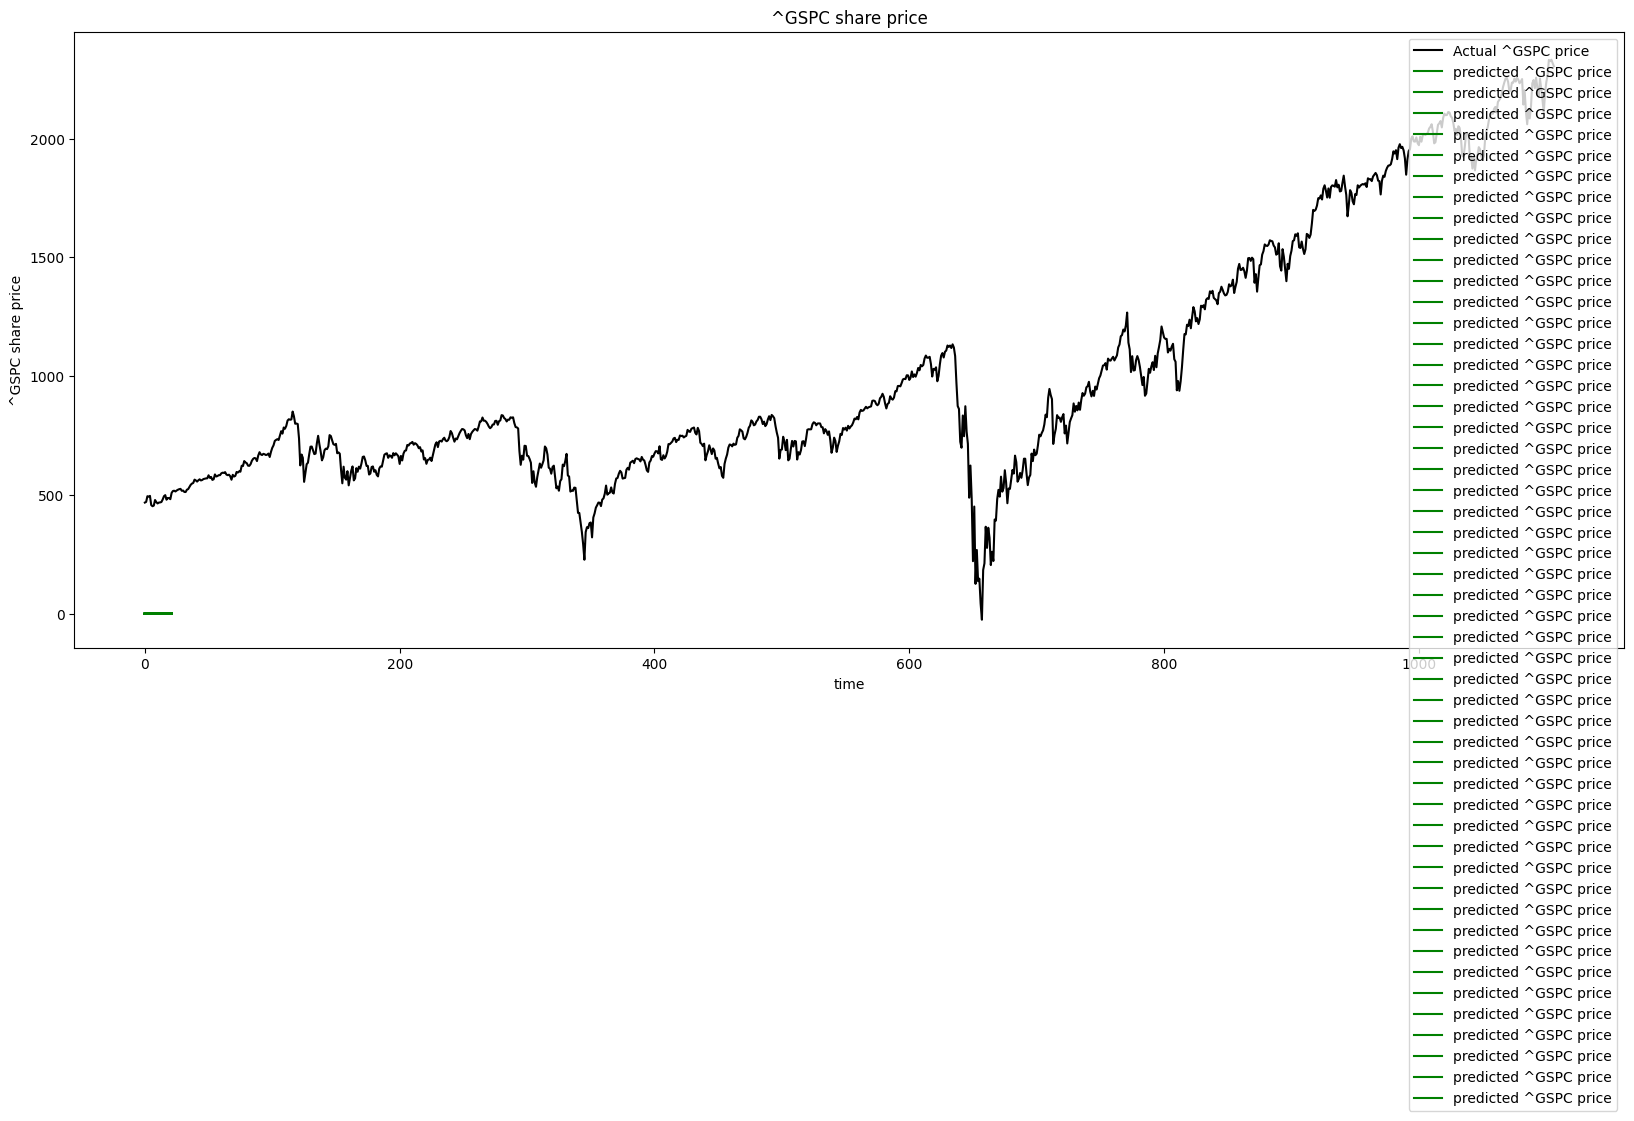

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color='green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
# plt.xlim(0,9)
plt.legend()
plt.show()

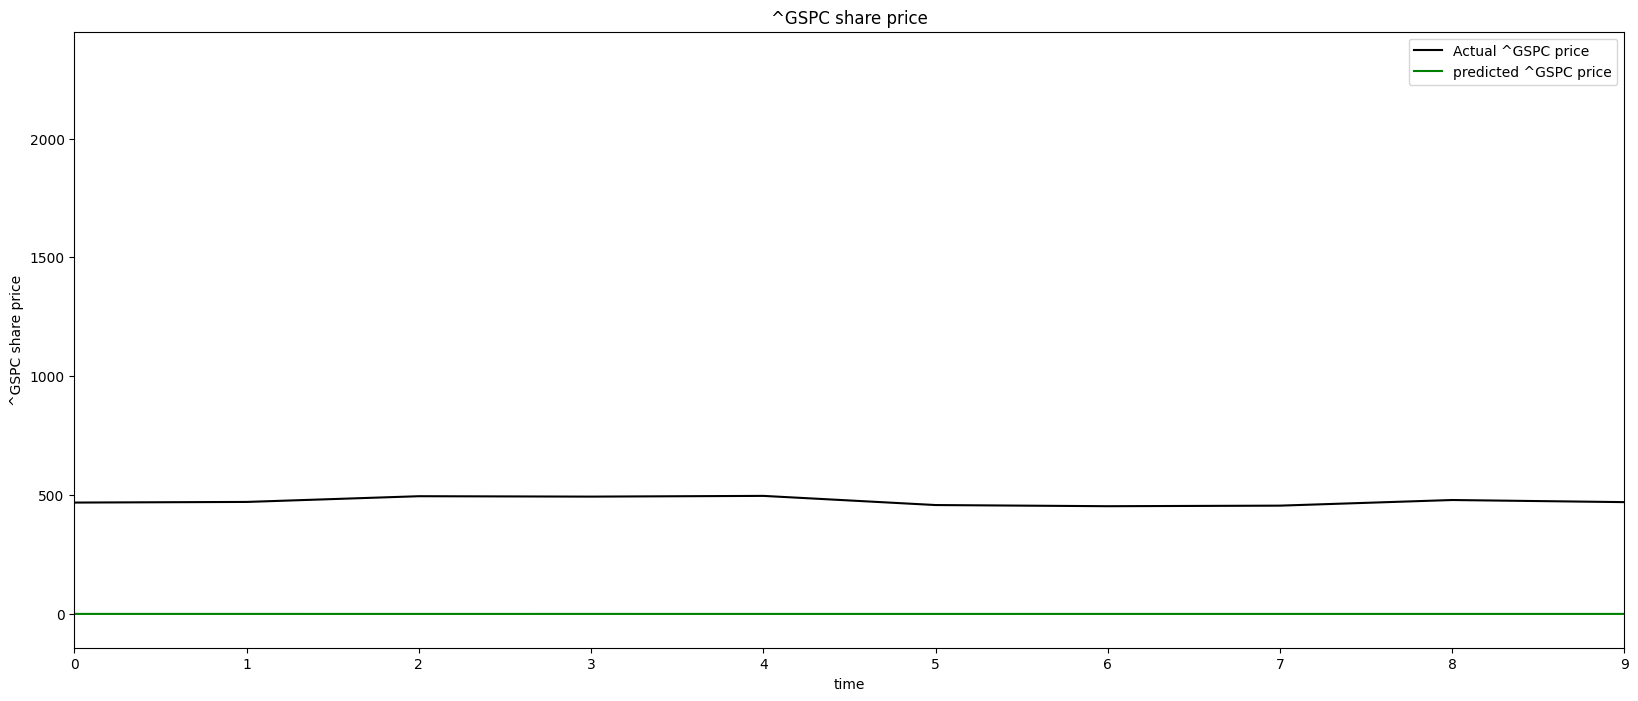

In [26]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices[0], color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.xlim(0, 9)
# plt.ylim(400, 510)
plt.legend()
plt.show()

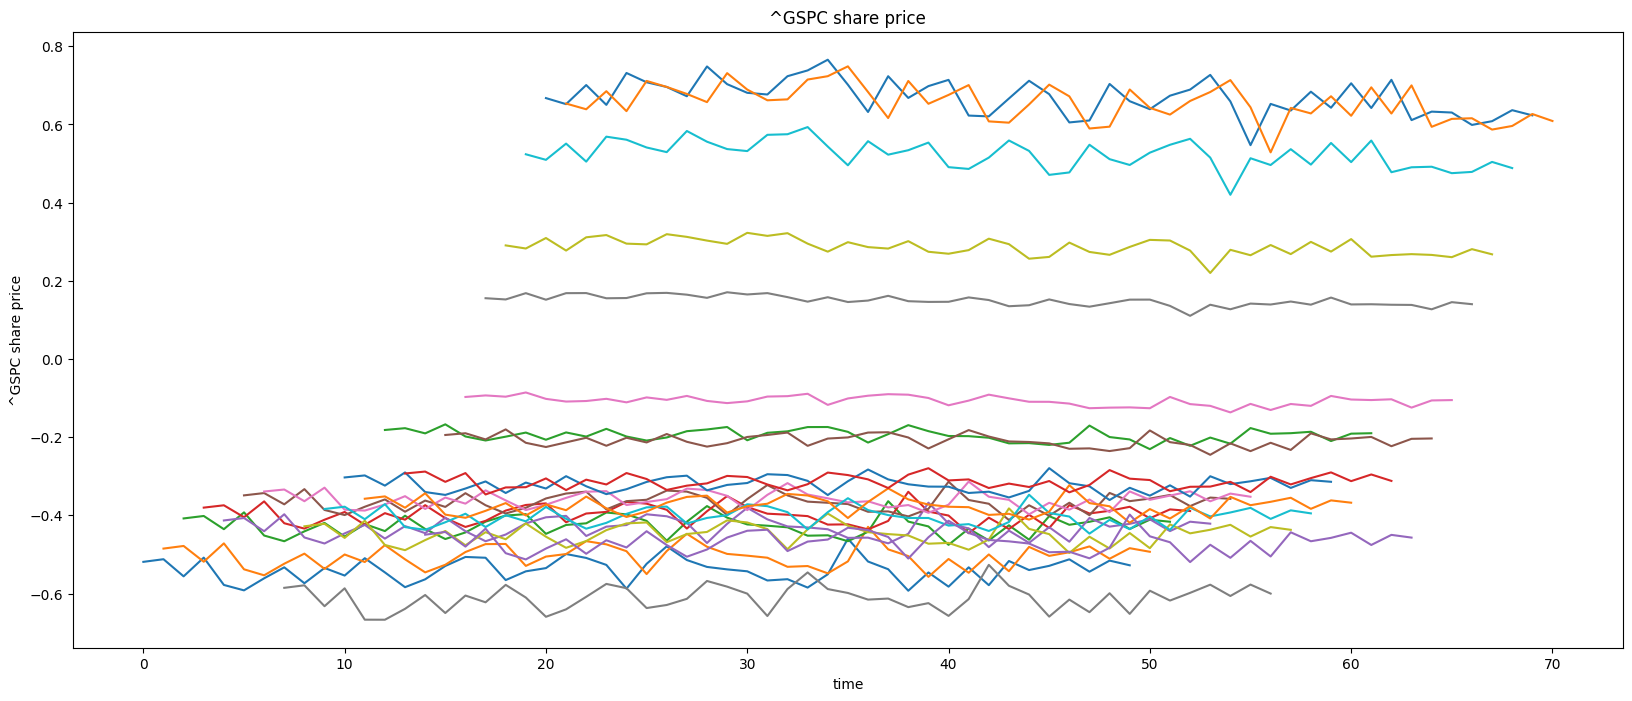

In [32]:
plt.figure(figsize=(20, 8))
# for i in range(0, len(y_test), 1):
#     start = i
#     singal = y_test[start]
#     plt.plot(range(start,len(singal)+start), singal, label=f"predicted {COMPANY} price")
for i in range(0, len(predicted_prices), 1):
    start = i
    singal = predicted_prices[start]
    plt.plot(range(start,len(singal)+start), singal, label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")

# plt.legend()
plt.show()

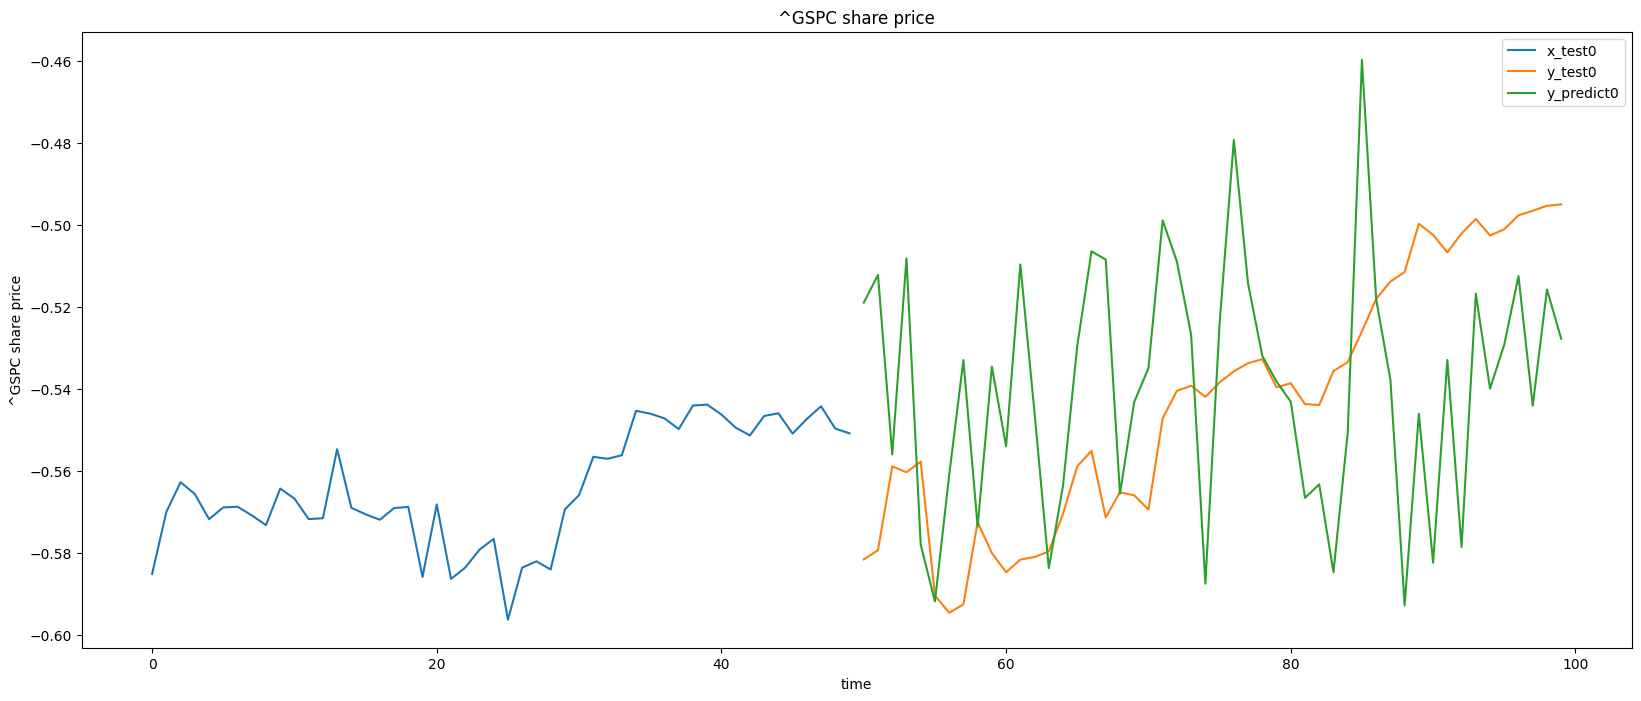

In [28]:
plt.figure(figsize=(20, 8))
for i in range(0, 1):
    start = i
    singal = x_test[start]
    plt.plot(range(start,len(singal)+start), singal, label=f"x_test{i}")
for i in range(0, 1):
    start = i
    singal = y_test[start]
    plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_test{i}")
for i in range(0, 1):
    start = i
    singal = predicted_prices[start]
    plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_predict{i}")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

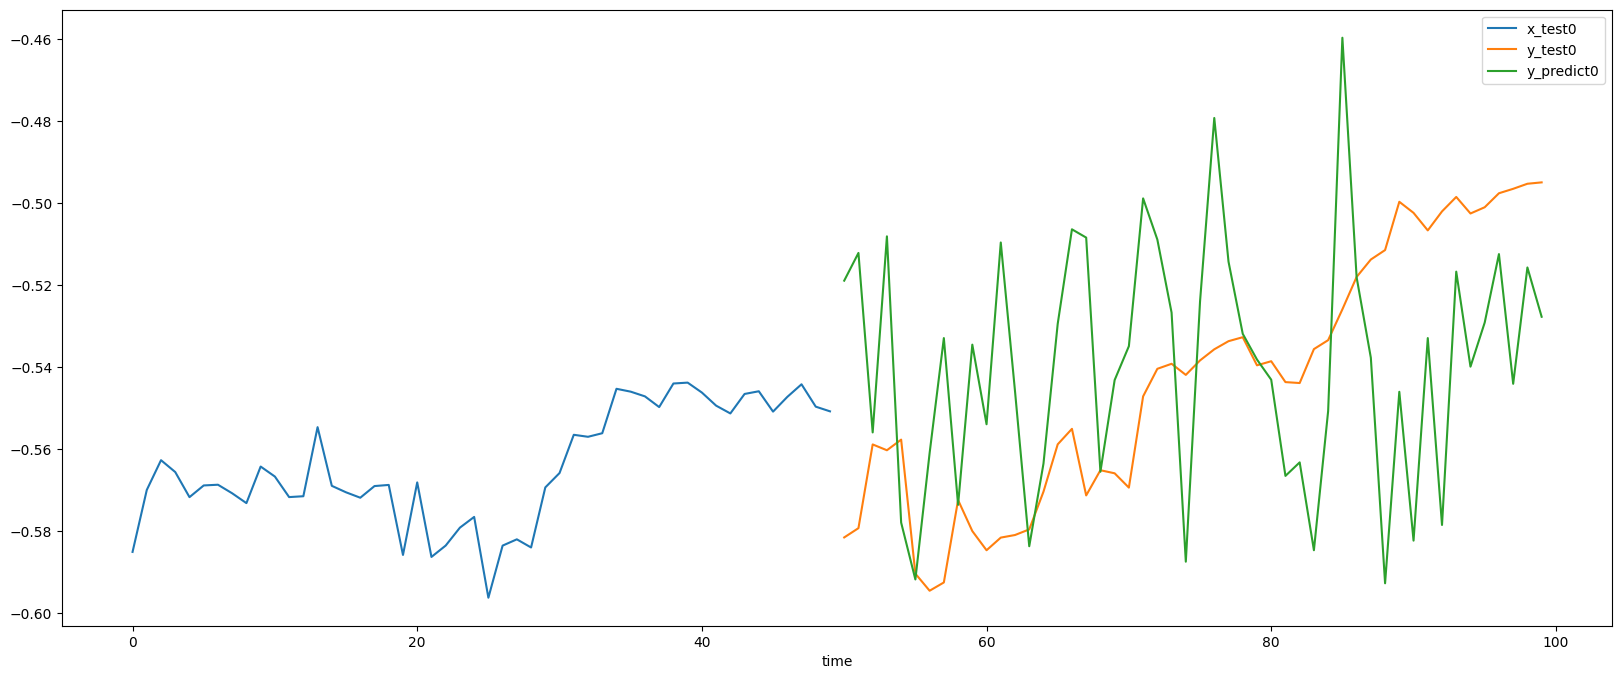

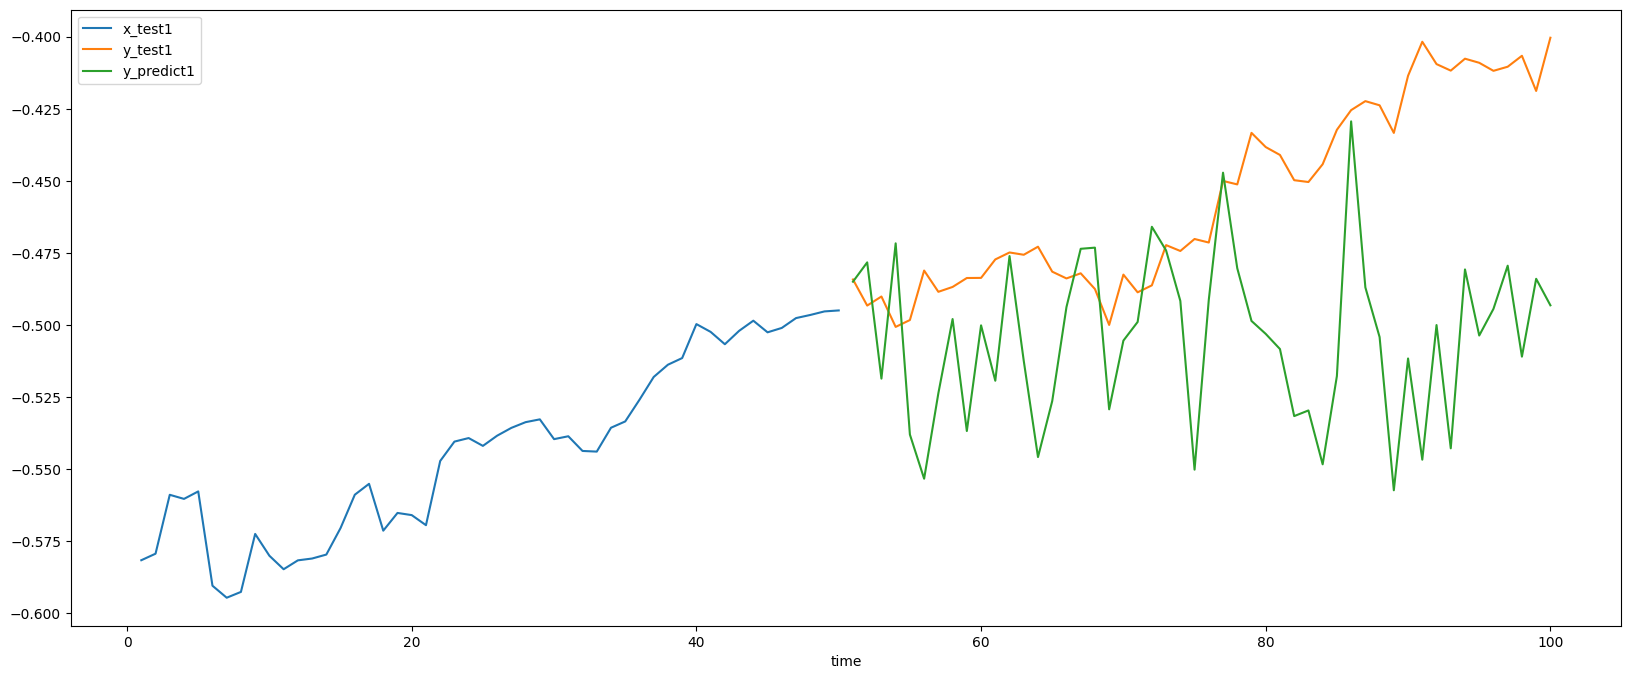

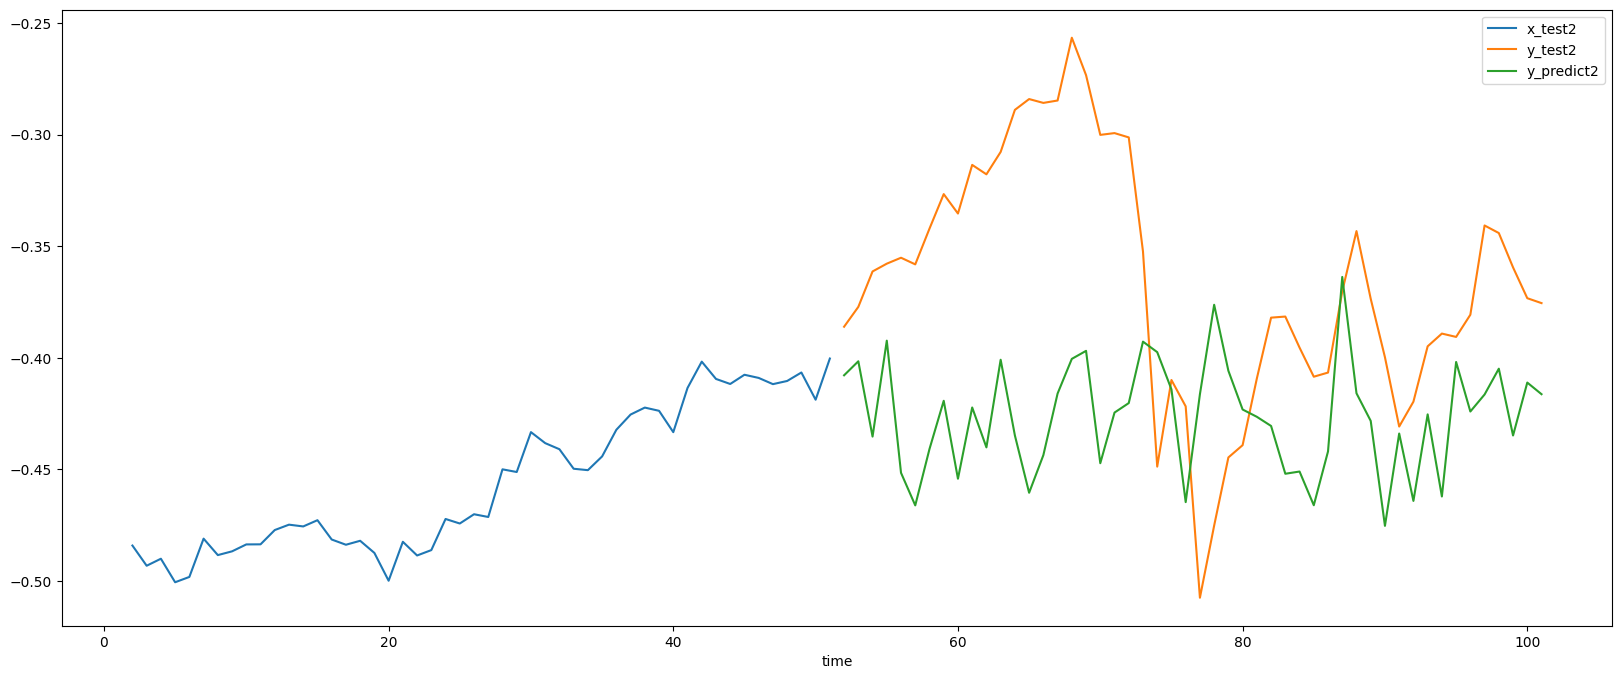

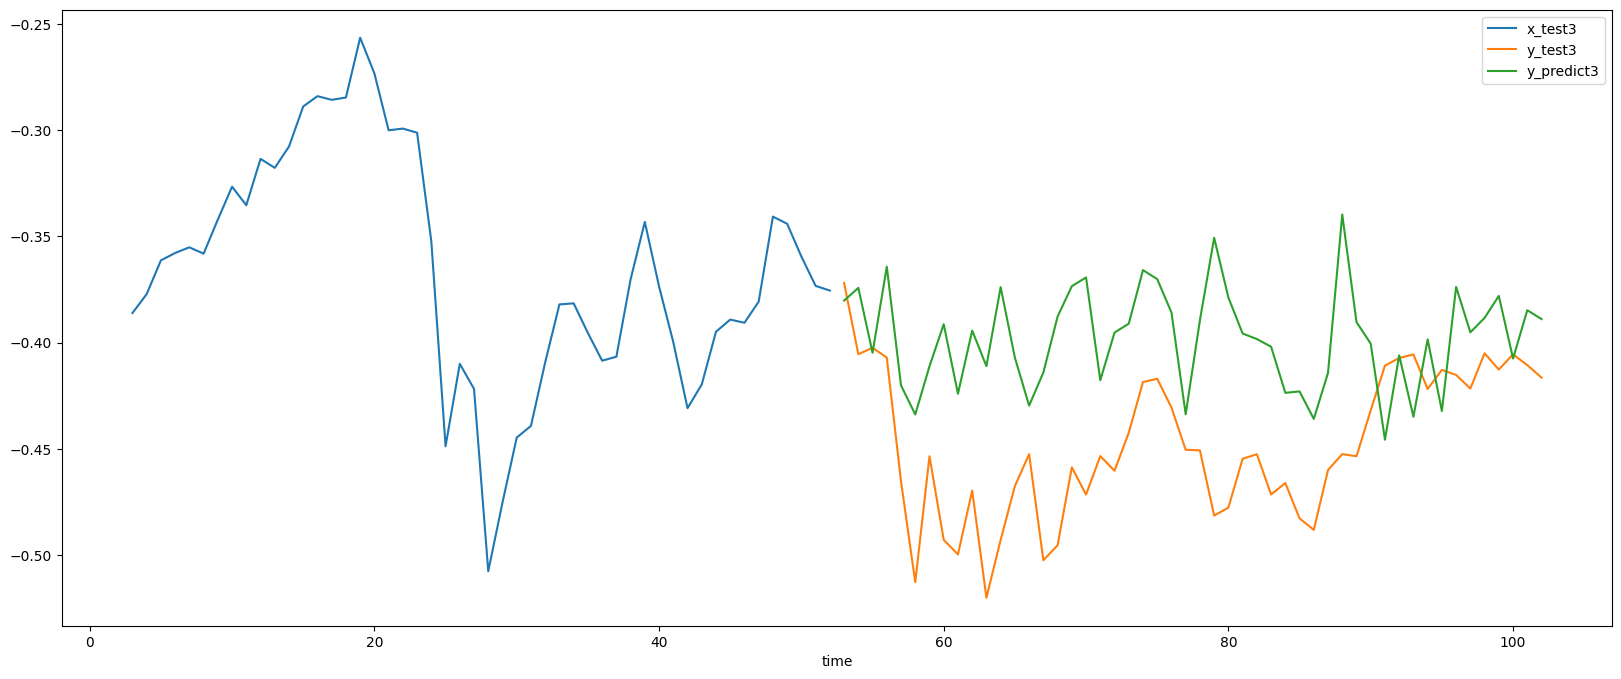

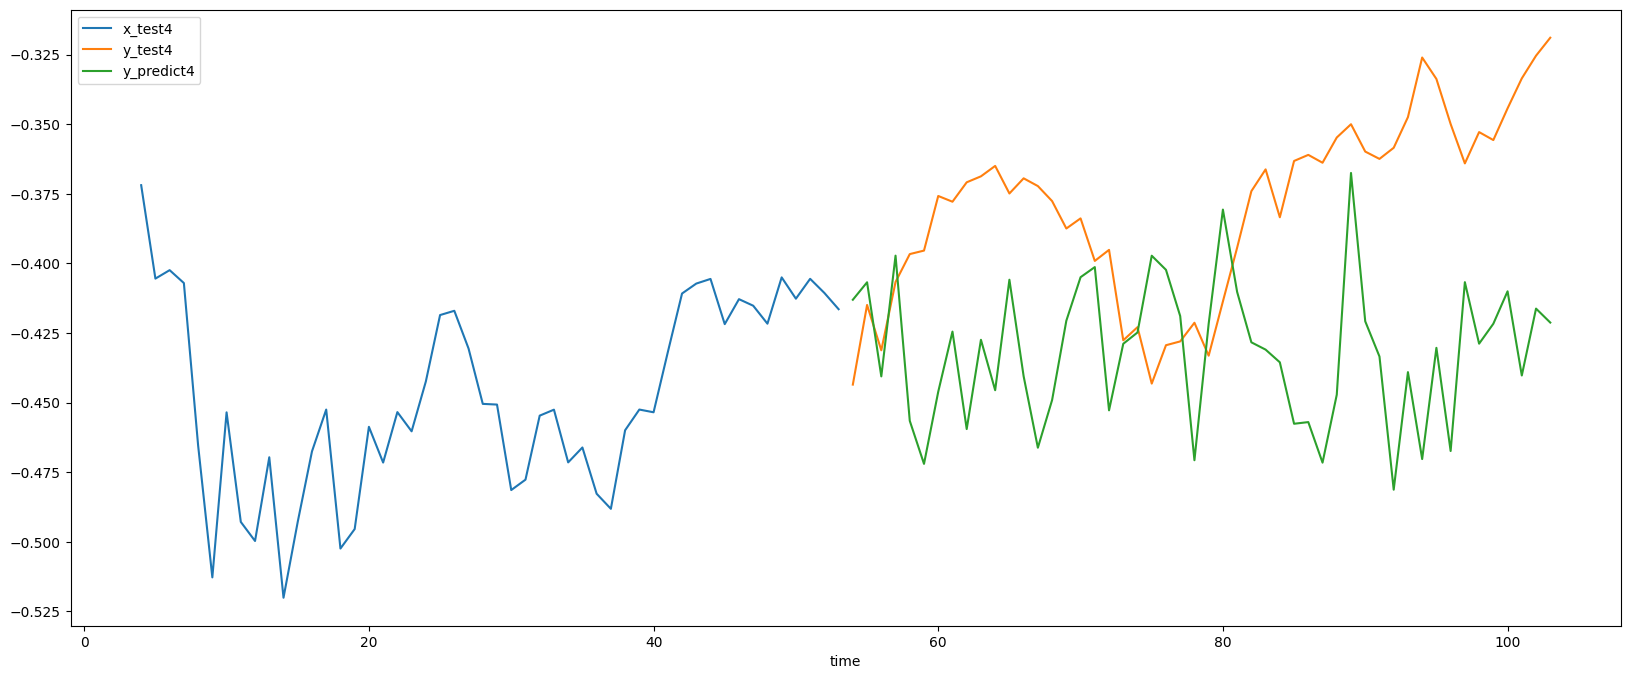

In [29]:
for num in range(0, 5):
    plt.figure(figsize=(20, 8))
    for i in range(num, num+1):
        start = i
        singal = x_test[start]
        plt.plot(range(start,len(singal)+start), singal, label=f"x_test{i}")
    for i in range(num, num+1):
        start = i
        singal = y_test[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_test{i}")
    for i in range(num, num+1):
        start = i
        singal = predicted_prices[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_predict{i}")
    plt.xlabel("time")
    plt.legend()
    plt.show()